<a href="https://colab.research.google.com/github/k3larra/generalisation/blob/pc/shapes_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training model on basic 2D shapes
This code accompanies the paper with the title "Deep Learning, generalisation and concepts".



# Setup

In [ ]:
import os
import csv
import sys
import uuid
from os import listdir, mkdir
from os.path import isfile, join
import json
import random
random.seed(131254) # Set seed for reproducibility.
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torch.optim import lr_scheduler
from torchvision import transforms
from torchvision.transforms import functional as transformsF
from PIL import Image
import matplotlib.pyplot as plt
from zipfile import ZipFile
print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1.13.0+cu116


In [ ]:
%%capture
!mkdir '/content/study'
!wget https://raw.githubusercontent.com/k3larra/generalisation/pc/models/models.json -P /content/study

### Training set

In [ ]:
#The kaggle token
#!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"larsholmberg","key":"4b2c0a02173702dff658e9ba068fb558"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download smeschke/four-shapes
with ZipFile('/content/four-shapes.zip', 'r') as archive:
  archive.extractall('/content')

 83% 18.0M/21.6M [00:00<00:00, 183MB/s]
100% 21.6M/21.6M [00:00<00:00, 199MB/s]


## Dataloader


In [ ]:
# Create annotation file for training!
shape_path = "/content/shapes"
shapes_to_ignore = ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']
labels_to_ignore = []
with open('/content/shapes/shapes.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_location', 'label']) # Write header
    for dirs in listdir("/content/shapes"):
        if dirs in labels_to_ignore: #Ignore label!
          continue
#         print(dirs)
        if(dirs.endswith(".csv")):
            continue
        for f in listdir(join("/content/shapes", dirs)):
            if f in shapes_to_ignore: #ignore the images! 
              continue
            elif(join("/content/shapes", dirs, f).endswith(".csv")):
                continue
            elif isfile(join("/content/shapes", dirs, f)):
                writer.writerow([join(dirs, f), dirs])

In [ ]:
# Create classes
!wget https://raw.githubusercontent.com/k3larra/generalisation/pc/classes.txt -P /content
with open("classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
num_classes = len(categories)

def label_to_idx(label):
  return categories.index(label)

def idx_to_label(idx):
  return categories[idx]

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.resizer = transforms.Resize(size=(299, 299)) 
    def __len__(self):
        return len(self.img_labels)
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path,ImageReadMode.RGB) # Converts to tensor Here reading RGB
        #image = read_image(img_path,ImageReadMode.UNCHANGED) # Converts to tensor
        image = image.float() #Why since we have [0..255] ?
        image /= 255. # And why, perhaps normalise after transforms ?
        label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(label_to_idx(label))
        # ADDDITIONS TO TRANSFORM THE INPUT
        r = random.random() # 33% (equal probability) to zoom-in, zoom-out, dont transform
        if r < 0.33: #zoom-in the shape!
          top = random.randrange(0, 40) 
          left = top
          dif = 40 - top
          w = 120 + dif
          h = w
          image = transformsF.resized_crop(image, top, left, h, w, size=(200, 200))
        elif r < 0.66: #zoom-out the shape!
          pad = random.randrange(0, 300)
          image = transforms.Pad(padding=pad, fill=1)(image)
        image = self.resizer(image) #I guess 299,299 is ok since we do 224x 224 later if ResNet but effisientet use [384,384], inception [299,299], but then our shape images are 200,200
        # END OF ADDITIONS!
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        #image = image.repeat(3, 1, 1) removed since RGB
        return image, label

## Create train and validation set

In [ ]:
#transform=ResNet50_Weights.IMAGENET1K_V2.transforms()
#shapes_dataset = CustomImageDataset('/content/shapes/shapes.csv', '/content/shapes',transform=transform, target_transform=None)
shapes_dataset = CustomImageDataset('/content/shapes/shapes.csv', '/content/shapes',transform=None, target_transform=None)
input, label = shapes_dataset[0]
training_size = int(len(shapes_dataset)*0.9)
validation_size = int(len(shapes_dataset) - training_size)
train_set, val_set = torch.utils.data.random_split(shapes_dataset, [training_size, validation_size], generator=torch.Generator().manual_seed(42)) #Use seed for reproducability
training_loader = DataLoader(train_set, batch_size=32, shuffle=True)  #32,64
validation_loader = DataLoader(val_set, batch_size=32, shuffle=True)  #32,64

# Training set information 

#ALBERTO HERE PROBLEM OR AT LEAST A QUESTION!!!

You have to download the transforms below... But then if the transforms are used the numbers are not between [0..1] or [0..255]



torch.Size([299, 299, 3])
Max:  tensor(1.) Min:  tensor(0.)
torch.Size([299, 299, 3])
Max:  tensor(1.) Min:  tensor(0.)
torch.Size([299, 299, 3])
Max:  tensor(1.) Min:  tensor(0.)
torch.Size([299, 299, 3])
Max:  tensor(1.) Min:  tensor(0.)
torch.Size([299, 299, 3])
Max:  tensor(1.) Min:  tensor(0.)
torch.Size([299, 299, 3])
Max:  tensor(1.) Min:  tensor(0.)
torch.Size([299, 299, 3])
Max:  tensor(1.) Min:  tensor(0.)
torch.Size([299, 299, 3])
Max:  tensor(1.) Min:  tensor(0.)
torch.Size([299, 299, 3])
Max:  tensor(1.) Min:  tensor(0.)
torch.Size([299, 299, 3])
Max:  tensor(1.) Min:  tensor(0.)
torch.Size([299, 299, 3])
Max:  tensor(1.) Min:  tensor(0.)
torch.Size([299, 299, 3])
Max:  tensor(1.) Min:  tensor(0.)


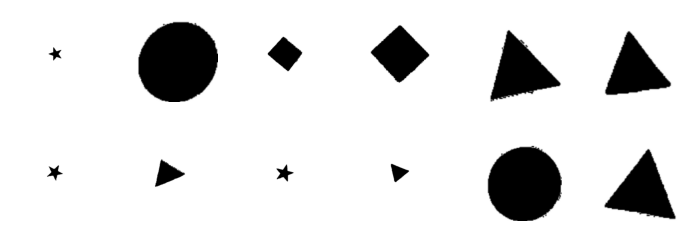

In [ ]:
transform=ResNet50_Weights.IMAGENET1K_V2.transforms()
#shapes_dataset = CustomImageDataset('/content/shapes/shapes.csv', '/content/shapes',transform=transform, target_transform=None)
shapes_dataset = CustomImageDataset('/content/shapes/shapes.csv', '/content/shapes',transform=None, target_transform=None)
# I find it strange that using the standard ResNet transform creates images that are not [0..1] or [0..255]  
figure = plt.figure(figsize=(12, 4))
cols, rows = 6, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(shapes_dataset), size=(1,)).item() # Get rnd_id
    sample = shapes_dataset[sample_idx] # index dataset (gets you the img and label - index)
    img, label = shapes_dataset[sample_idx] # index dataset (gets you the img and label - index)
    figure.add_subplot(rows, cols, i)
    img = img.permute(1,2,0)
    print(img.shape)
    print("Max: ",torch.max(img), "Min: ", torch.min(img))
    plt.axis("off")
    plt.imshow(img) # put channel as the last dimension out, vmin=0, vmax=255
plt.show()

In [ ]:
for inputs, labels in training_loader:
  print(inputs.shape)
  print('Training set size',int(len(inputs)))
  #print(inputs)
  print(labels.shape)
  break

torch.Size([32, 3, 299, 299])
Training set size 32
torch.Size([32])


# Train and save models

In [ ]:
def train_model(model, criterion, optimizer):
    jsonData={}
    best_acc = 0.0
    model.train()   # Set model to train mode
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)    
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()     
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)     
    epoch_loss = running_loss / training_size
    epoch_acc = running_corrects.double() / training_size
    jsonData["train_loss"] = round(epoch_loss,3)
    jsonData["epoch_acc"] = round(epoch_acc.item(),3)
    print('train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return jsonData
    
def test_model(model, criterion):
  jsonData={}
  best_acc = 0.0
  model.eval()   # Set model to evaluate mode
  running_loss = 0.0
  running_corrects = 0
  for inputs, labels in validation_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
  epoch_loss = running_loss / validation_size
  epoch_acc = running_corrects.double() / validation_size
  jsonData["test_loss"] = round(epoch_loss,3)
  jsonData["epoch_acc"] = round(epoch_acc.item(),3)
  print('test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
  return jsonData

In [ ]:
#Models to train
from torchvision.models import resnet50, ResNet50_Weights
model_resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
#model_resnet50 = resnet50(weights=weights)
model_resnet50.name = "ResNet50"
model_resnet50.weights = "ResNet50_Weights.IMAGENET1K_V2"
#training_loader,validation_loader = createTraining_and_validation_loader(transform=ResNet50_Weights.IMAGENET1K_V2.transforms())

# from torchvision.models import resnet101, ResNet101_Weights
# model_resnet101 = resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)
# model_resnet101.name = "ResNet101"

# 152 seems to be to big for standard colab and the batch size used
# from torchvision.models import resnet152, ResNet152_Weights
# model_resnet152 = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)
# model_resnet152.name = "ResNet152"

# from torchvision.models import googlenet, GoogLeNet_Weights
# model_googlenet = googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1)
# model_googlenet.name = "GoogLeNet"

# from torchvision.models import inception_v3, Inception_V3_Weights
# model_inception_v3 = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
# model_inception_v3.name = "Inception_V3"

# from torchvision.models import convnext_tiny,ConvNeXt_Tiny_Weights
# model_convnext_tiny = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
# model_convnext_tiny.name = "ConvNeXt_Tiny"

experiment_models = [model_resnet50]
experiment_weights= [ResNet50_Weights.IMAGENET1K_V2]

# experiment_models = [model_resnet50,   
#                      model_resnet152,
#                      model_googlenet,
#                      model_inception_v3,
#                      model_convnext_tiny]
# experiment_weights= [ResNet50_Weights.IMAGENET1K_V2,
#                      ResNet152_Weights.IMAGENET1K_V2,
#                      GoogLeNet_Weights.IMAGENET1K_V1,
#                      Inception_V3_Weights.IMAGENET1K_V1,
#                      ConvNeXt_Tiny_Weights.IMAGENET1K_V1]

In [ ]:
#Run training and add information to the JSON file
model_save_path = '/content/study/'
json_filename = 'models.json'
model_ft=None
num_epochs = 4
if isfile(model_save_path + json_filename) is True:
  with open(model_save_path + json_filename) as outfile:
    experiment_json_data = json.load(outfile)
else:
  experiment_json_data={}
for experiment_model,experiment_weight in zip(experiment_models,experiment_weights):
  jsonData={}
  id = str(uuid.uuid4())
  model_weights_path = id+'_weights_model.pth'
  complete_model_path = id+'_complete_model.pth'
  jsonData["model_weights_path"] = model_weights_path
  jsonData["complete_model_path"] = complete_model_path
  jsonData["model_name"] = experiment_model.name
  jsonData["weights"]= model_resnet50.weights
  jsonData["num_epocs"] = num_epochs
  jsonData["transformation"] = "transforms.Resize(size=(299, 299))"
  jsonData["time"] = time.asctime( time.localtime(time.time()))
  print('--')
  model_ft = experiment_model
  model_ft.eval()
  model_ft = model_ft.to(device)
  print("Training:",model_ft.name)
  criterion = nn.CrossEntropyLoss()
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
  jsonTrain={}
  train=0
  test = 0
  for epoch in range(num_epochs):
      print()
      print('Epoch {}/{}'.format(epoch, num_epochs-1))
      jsonTrain["train_"+str(epoch)] = train_model(model_ft, criterion, optimizer_ft)
      jsonTrain["test_"+str(epoch)] = test_model(model_ft, criterion)
      scheduler.step()
  torch.save(model_ft.state_dict(), model_weights_path)
  torch.save(model_ft,   complete_model_path)
  jsonData["training"] = jsonTrain
  experiment_json_data[id] = jsonData
# print(json.dumps(experiment_json_data, indent=2))
with open(model_save_path + json_filename, 'w') as outfile:
  outfile.write(json.dumps(experiment_json_data))

In [ ]:
zip_name = "models"
import shutil
shutil.make_archive("/content/"+zip_name, 'zip', "/content/study")

'/content/models.zip'